In [19]:
import pandas as pd
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import cross_validate, KFold,StratifiedKFold,cross_val_score
from sklearn.metrics import make_scorer, f1_score, roc_auc_score,average_precision_score
import optuna
import numpy as np
import warnings
import shap
import matplotlib.pyplot as plt
from test_utils import plot_density, plot_precision_recall_curve, plot_roc_curve,calculate_dr_with_ar, plot_ar_vs_dr
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_parquet('data/data_train.parquet')
categorical_columns = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
                       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
                       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 
                       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 
                       'OCCUPATION_TYPE']


df_train[categorical_columns] = df_train[categorical_columns].astype('category')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20903 entries, 5024703 to 5149294
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   target               20903 non-null  int64   
 1   CODE_GENDER          20903 non-null  category
 2   FLAG_OWN_CAR         20903 non-null  category
 3   FLAG_OWN_REALTY      20903 non-null  category
 4   CNT_CHILDREN         20903 non-null  int64   
 5   AMT_INCOME_TOTAL     20903 non-null  int64   
 6   NAME_INCOME_TYPE     20903 non-null  category
 7   NAME_EDUCATION_TYPE  20903 non-null  category
 8   NAME_FAMILY_STATUS   20903 non-null  category
 9   NAME_HOUSING_TYPE    20903 non-null  category
 10  DAYS_EMPLOYED        20903 non-null  int64   
 11  FLAG_WORK_PHONE      20903 non-null  category
 12  FLAG_PHONE           20903 non-null  category
 13  FLAG_EMAIL           20903 non-null  category
 14  OCCUPATION_TYPE      20903 non-null  category
 15  CNT_FAM_MEMBERS 

In [3]:
X_train = df_train.drop(columns=['target'])  
y_train = df_train['target']

In [4]:
print('X train dim', X_train.shape)
print('dist target', y_train.value_counts(normalize=True))

X train dim (20903, 15)
dist target target
1    0.922547
0    0.077453
Name: proportion, dtype: float64


In [25]:
def objective(trial):

    xgb_params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',
        'enable_categorical': True,
        'seed': 35,
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 0.80),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.80),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.5, 5.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'lambda': trial.suggest_float('lambda', 0.5, 5.0),
        'scale_pos_weight': trial.suggest_discrete_uniform('scale_pos_weight', 0.05, 0.10,.01)
    }

    model_xgb = XGBClassifier(**xgb_params)
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    aucpr_scorer = make_scorer(average_precision_score, needs_proba=True)
    cv_results = cross_val_score(model_xgb, X_train, y_train, cv=kf, scoring=aucpr_scorer)


    return cv_results.mean()

In [26]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

[I 2024-09-21 21:49:27,326] A new study created in memory with name: no-name-37840d74-b859-4a15-ae2e-cafe33075878
[I 2024-09-21 21:49:29,318] Trial 0 finished with value: 0.9517272542358666 and parameters: {'max_depth': 7, 'learning_rate': 0.09891267826021452, 'subsample': 0.5132343794533667, 'colsample_bytree': 0.5935882503874822, 'min_child_weight': 2, 'gamma': 0.8953522018376607, 'n_estimators': 742, 'lambda': 2.74611237108607, 'scale_pos_weight': 0.07}. Best is trial 0 with value: 0.9517272542358666.
[I 2024-09-21 21:49:30,141] Trial 1 finished with value: 0.9309502663559234 and parameters: {'max_depth': 5, 'learning_rate': 0.04946044358848078, 'subsample': 0.602529396392727, 'colsample_bytree': 0.7106811479034525, 'min_child_weight': 7, 'gamma': 4.517689821407066, 'n_estimators': 840, 'lambda': 3.9210950961689286, 'scale_pos_weight': 0.060000000000000005}. Best is trial 0 with value: 0.9517272542358666.
[I 2024-09-21 21:49:30,831] Trial 2 finished with value: 0.9372273616187714 an

In [27]:
print("Best parameters found by Optuna:")
print(study.best_params)

print("\nBest metric (objective value):")
print(study.best_value)

Best parameters found by Optuna:
{'max_depth': 18, 'learning_rate': 0.0027453834796221867, 'subsample': 0.7496236157666976, 'colsample_bytree': 0.7987660522678317, 'min_child_weight': 1, 'gamma': 0.5053080595142008, 'n_estimators': 671, 'lambda': 0.5050427080048671, 'scale_pos_weight': 0.1}

Best metric (objective value):
0.9601881652916707


### Eval 

In [28]:
default_params = {'objective': 'binary:logistic',
        'eval_metric': 'aucpr',
        'enable_categorical': True,
        'seed': 35}
best_params = study.best_params
default_params.update(best_params)
xgb_model = xgb.XGBClassifier(**default_params)
xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7987660522678317, device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric='aucpr', feature_types=None, gamma=0.5053080595142008,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.5050427080048671,
              learning_rate=0.0027453834796221867, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=18, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=671, n_jobs=None,
              num_parallel_tree=None, ...)

In [29]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7987660522678317, device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric='aucpr', feature_types=None, gamma=0.5053080595142008,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.5050427080048671,
              learning_rate=0.0027453834796221867, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=18, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=671, n_jobs=None,
              num_parallel_tree=None, ...)

In [30]:
### cargamos data test
df_test = pd.read_parquet('data/data_test.parquet')
categorical_columns = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
                       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
                       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 
                       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 
                       'OCCUPATION_TYPE']


df_test[categorical_columns] = df_test[categorical_columns].astype('category')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5226 entries, 5033998 to 5116921
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   target               5226 non-null   int64   
 1   CODE_GENDER          5226 non-null   category
 2   FLAG_OWN_CAR         5226 non-null   category
 3   FLAG_OWN_REALTY      5226 non-null   category
 4   CNT_CHILDREN         5226 non-null   int64   
 5   AMT_INCOME_TOTAL     5226 non-null   int64   
 6   NAME_INCOME_TYPE     5226 non-null   category
 7   NAME_EDUCATION_TYPE  5226 non-null   category
 8   NAME_FAMILY_STATUS   5226 non-null   category
 9   NAME_HOUSING_TYPE    5226 non-null   category
 10  DAYS_EMPLOYED        5226 non-null   int64   
 11  FLAG_WORK_PHONE      5226 non-null   category
 12  FLAG_PHONE           5226 non-null   category
 13  FLAG_EMAIL           5226 non-null   category
 14  OCCUPATION_TYPE      5226 non-null   category
 15  CNT_FAM_MEMBERS  

In [31]:
### Split de test 
X_test = df_test.drop(columns=['target'])  
y_test = df_test['target']

In [32]:
### generamos las predicciones sobre test y las guardamos en el dataframe
df_test['pred_proba_model_1'] = xgb_model.predict_proba(X_test)[:,1]
df_test['pred_proba_model_1'].describe()

count    5226.000000
mean        0.652238
std         0.115511
min         0.167815
25%         0.599238
50%         0.679797
75%         0.732524
max         0.873040
Name: pred_proba_model_1, dtype: float64

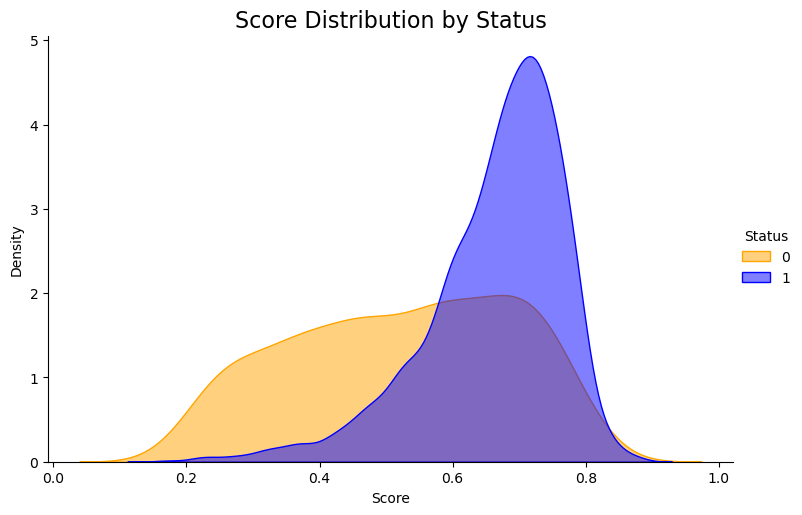

In [33]:
plot_density(df_test['pred_proba_model_1'], df_test['target'])
#El gráfico llega hasta 1.2 en el eje X porque seaborn.kdeplot estima la densidad de las distribuciones utilizando un suavizado 
#lo que puede extender los límites de los datos más allá del valor máximo real.

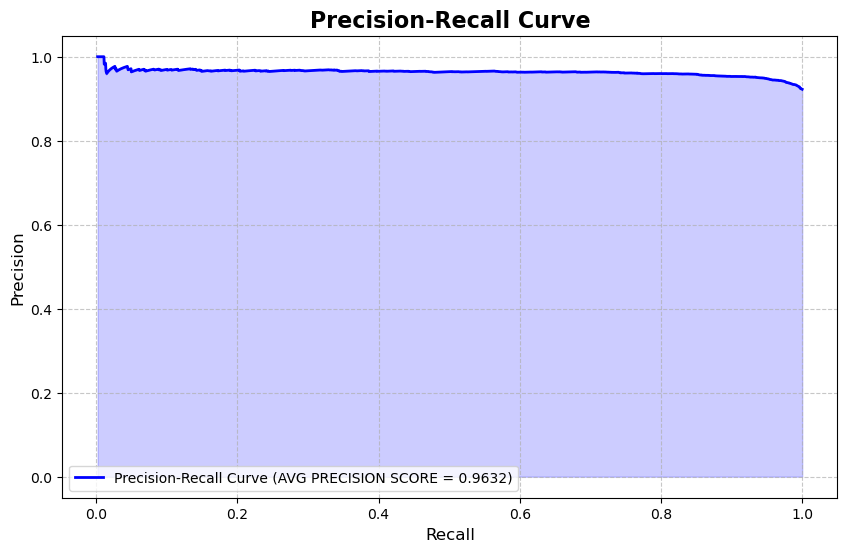

In [34]:
plot_precision_recall_curve(df_test['pred_proba_model_1'], df_test['target'])

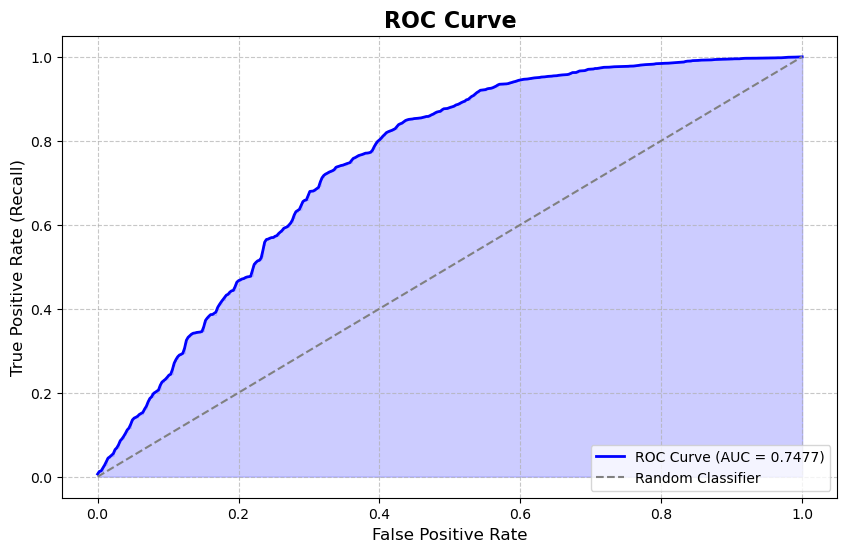

In [35]:
plot_roc_curve(df_test['pred_proba_model_1'], df_test['target'])

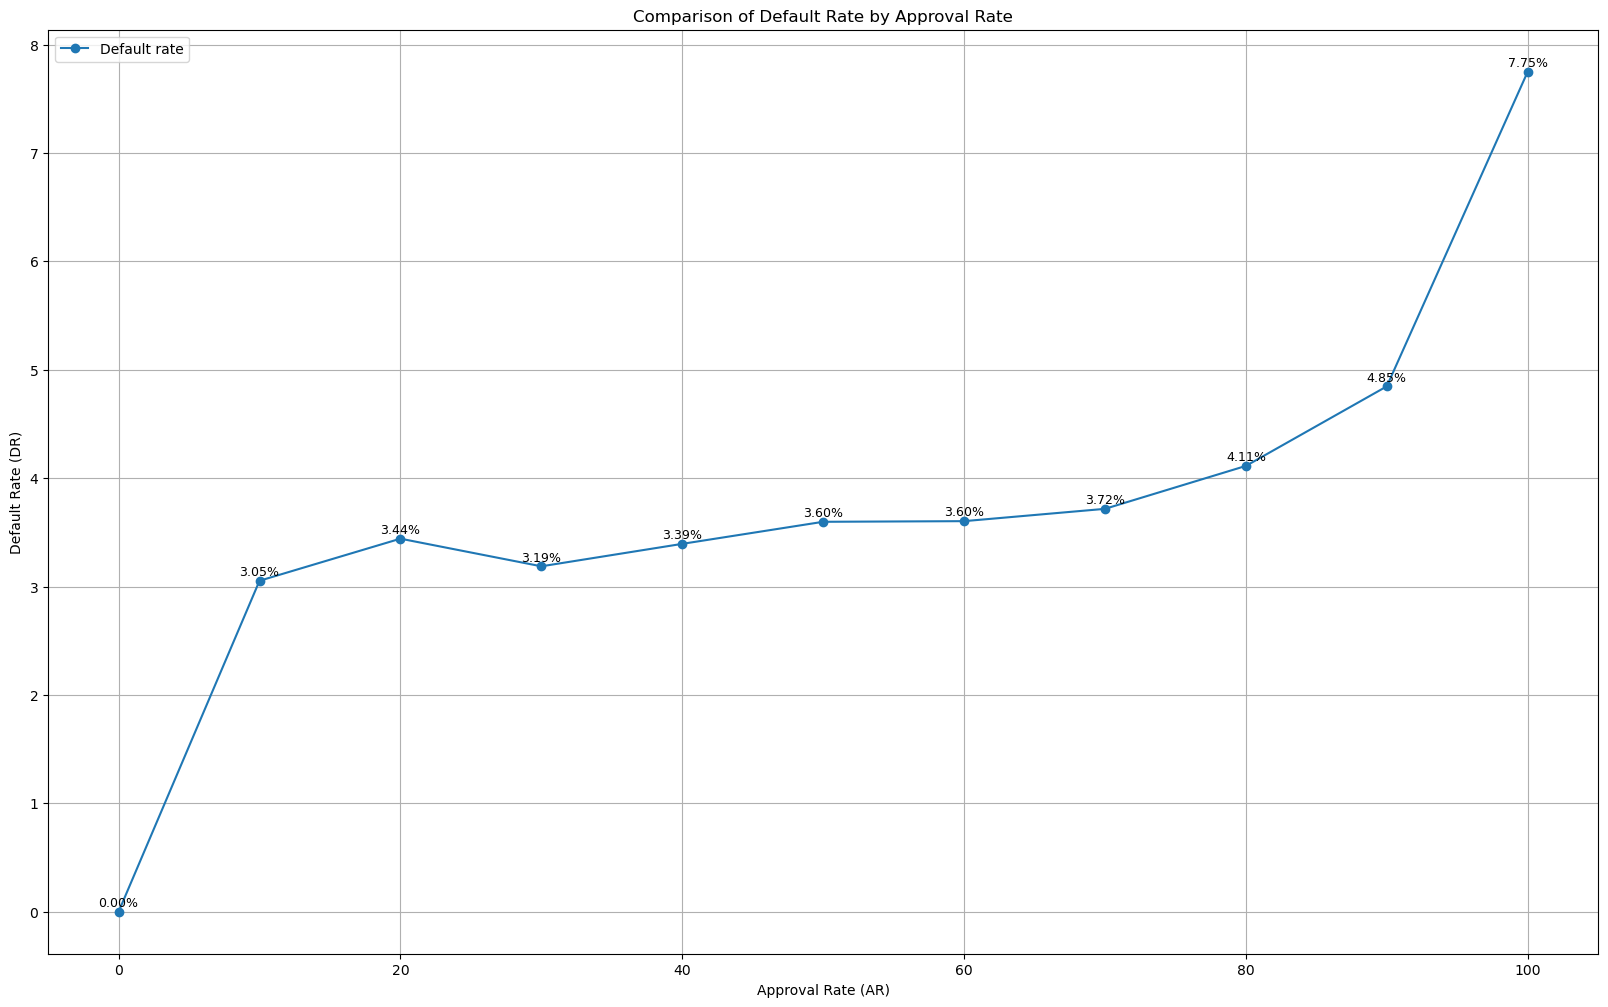

In [36]:
plot_ar_vs_dr(df_test['pred_proba_model_1'], df_test['target'])